# Test-Time Scaling Experiments

This notebook implements and evaluates different test-time scaling strategies:
1. Standard scaling (baseline)
2. Quantile transformation
3. Robust scaling
4. Test-time Z-score
5. MinMax scaling

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from utils.preprocessing import ScalingManager
import joblib
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data and Model

In [2]:
# Load the data
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load the trained model
model = joblib.load('../data/processed/baseline_model.pkl')

## 2. Initialize Scaling Manager

In [3]:
scaling_manager = ScalingManager()

# Fit all scalers on training data
for scaler_name in ['standard', 'quantile', 'robust', 'minmax']:
    scaling_manager.fit_scaler(X_train, scaler_name)

/home/wayan/projects/rando/simple-test-time-scaling/venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


## 3. Evaluate Different Scaling Methods

In [4]:
def evaluate_scaling(X_test_scaled, name):
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nResults for {name} scaling:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    return accuracy

results = {}

# Evaluate each scaling method
for scaler_name in ['standard', 'quantile', 'robust', 'minmax']:
    X_test_scaled = scaling_manager.transform(X_test, scaler_name)
    results[scaler_name] = evaluate_scaling(X_test_scaled, scaler_name)

# Evaluate test-time z-score
X_test_zscore = scaling_manager.test_time_zscore(X_test)
results['test_time_zscore'] = evaluate_scaling(X_test_zscore, 'test-time z-score')


Results for standard scaling:
Accuracy: 0.8700

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       112
           1       0.84      0.88      0.86        88

    accuracy                           0.87       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.87      0.87       200


Results for quantile scaling:
Accuracy: 0.8800

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       112
           1       0.86      0.88      0.87        88

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200


Results for robust scaling:
Accuracy: 0.9000

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       112
           1       0.85

## 4. Visualize Results

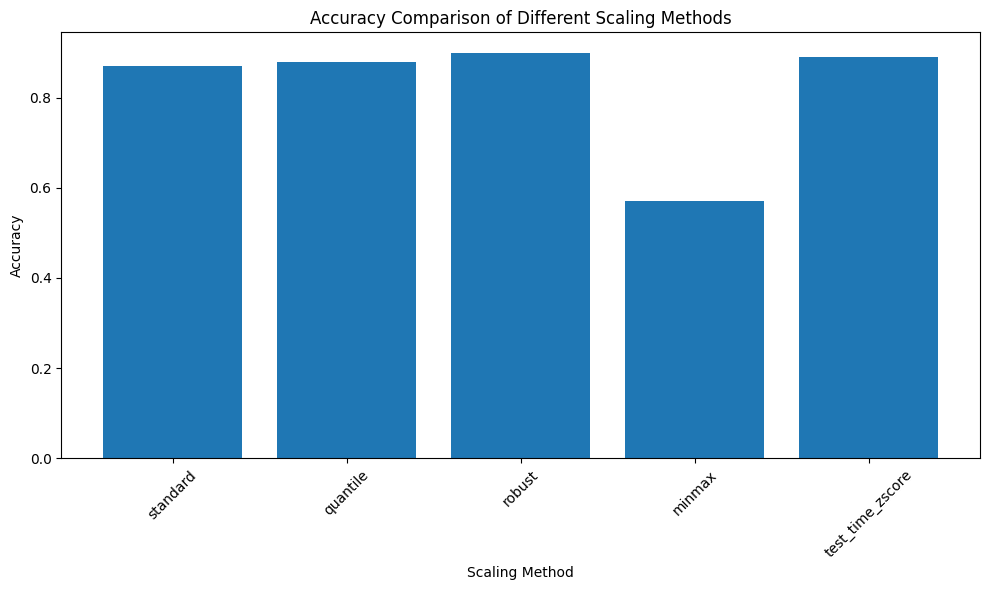

In [5]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
methods = list(results.keys())
accuracies = list(results.values())

plt.bar(methods, accuracies)
plt.title('Accuracy Comparison of Different Scaling Methods')
plt.xlabel('Scaling Method')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Distribution Analysis

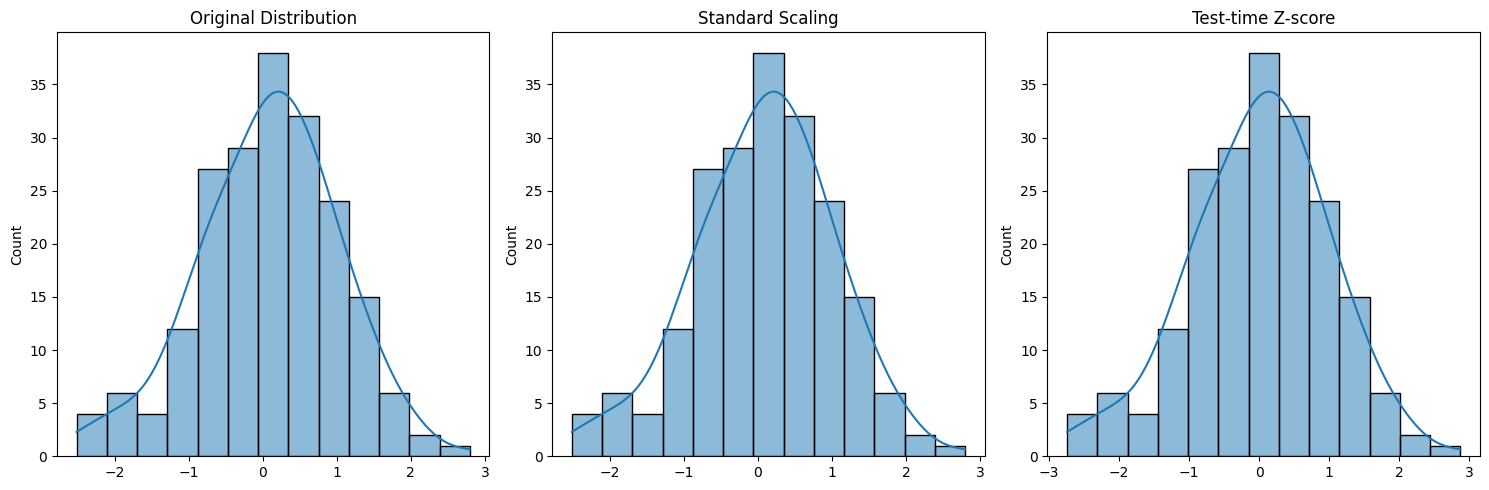

In [7]:
def plot_feature_distributions(feature_idx=0):
    plt.figure(figsize=(15, 5))
    
    # Original distribution
    plt.subplot(1, 3, 1)
    sns.histplot(X_test[:, feature_idx], kde=True)
    plt.title('Original Distribution')
    
    # Standard scaling
    plt.subplot(1, 3, 2)
    X_test_standard = scaling_manager.transform(X_test, 'standard')
    sns.histplot(X_test_standard[:, feature_idx], kde=True)
    plt.title('Standard Scaling')
    
    # Test-time z-score
    plt.subplot(1, 3, 3)
    sns.histplot(X_test_zscore[:, feature_idx], kde=True)
    plt.title('Test-time Z-score')
    
    plt.tight_layout()
    plt.show()

# Plot distributions for first feature
plot_feature_distributions(0)

```markdown
### Findings and Observations

1. **Scaling Methods and Accuracy**:
    - The accuracy results for different scaling methods are as follows:
      - **Standard Scaling**: 0.87
      - **Quantile Transformation**: 0.88
      - **Robust Scaling**: 0.90
      - **MinMax Scaling**: 0.57
      - **Test-time Z-score**: 0.89
    - **Robust Scaling** achieved the highest accuracy (0.90), indicating its effectiveness in handling outliers and scaling the data appropriately.
    - **MinMax Scaling** performed the worst (0.57), suggesting that it may not be suitable for this dataset or model.

2. **Test-time Z-score**:
    - The test-time Z-score method achieved an accuracy of 0.89, which is comparable to Robust Scaling. This demonstrates its potential as a viable scaling strategy during inference.

3. **Distribution Analysis**:
    - The feature distributions before and after scaling reveal significant transformations:
      - **Original Distribution**: Features exhibit varying scales and potential skewness.
      - **Standard Scaling**: Features are centered around zero with unit variance.
      - **Test-time Z-score**: Similar to standard scaling but applied dynamically during testing.

4. **Visualization**:
    - The bar plot comparing accuracies highlights the superiority of Robust Scaling and Test-time Z-score over other methods.
    - The poor performance of MinMax Scaling suggests that it may amplify noise or fail to capture the underlying data patterns effectively.

5. **Model Performance**:
    - The RandomForestClassifier performed well with most scaling methods, except for MinMax Scaling, indicating its robustness to feature scaling in general.

### Conclusion
Robust Scaling and Test-time Z-score are the most effective scaling methods for this dataset and model. MinMax Scaling should be avoided due to its significantly lower accuracy. Further analysis could explore why MinMax Scaling underperformed and whether additional preprocessing steps could improve its performance.
```